In [3]:
#!pip install -q -U "tensorflow-text==2.8.*"

ERROR: Could not install packages due to an OSError: [WinError 5] Accesso negato: 'C:\\Users\\lpdepersiis\\Anaconda3\\Lib\\site-packages\\~umpy\\core\\_multiarray_tests.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'c:\users\lpdepersiis\anaconda3\python.exe -m pip install --upgrade pip' command.


In [6]:
!pip install -q tf-models-official==2.7.0

You should consider upgrading via the 'c:\users\lpdepersiis\anaconda3\python.exe -m pip install --upgrade pip' command.


In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [2]:
tf.__version__

'2.8.0'

In [3]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url, untar=True, cache_dir='.', cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [5]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(5, 8):
        print(f'Review: {text_batch.numpy()[i]}')
        label = label_batch.numpy()[i]
        print(f'Label : {label} ({class_names[label]})')

Review: b"This flick reminds me some really bad science-fiction movies from 50's and 60's.It is not scary or interesting,but it's dull,cheesy and stupid.Special effects are laughable,all actors are ludicrous and the ending is simply awful.Don't waste your money,rent or buy something better.I give it 3.5 out of 10( I found this turkey quite amusing because of its stupidity)."
Label : 0 (neg)
Review: b'Finally a thriller which omits the car chases, explosions and other eye catching effects. The movie combines a simple plot (assasination of a french president) with an excellent background. It takes a look behind mans behavior with authorities, and explains why we would obey almost every order (even murder) which would be given to us.<br /><br />Furthermore it shows us how secret services can manipulate the run of history and how hardly they can be controlled. The best thing on this movie is, that there is no classic "Hollywood end" which can easily be predicted.'
Label : 1 (pos)
Review: b

In [6]:
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

In [7]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [8]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess, trainable=False)

In [9]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [11]:
bert_model = hub.KerasLayer(tfhub_handle_encoder, trainable=False)

In [12]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262885  0.99280983 -0.18611872  0.3667386   0.15233792  0.65504557
  0.9681154  -0.948627    0.00216077 -0.9877732   0.06842785 -0.9763061 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946352  0.34321296  0.3323149  ...  0.2130083   0.71020764
  -0.05771133]
 [-0.2874205   0.31981108 -0.2301845  ...  0.5845506  -0.2132971
   0.7269202 ]
 [-0.6615705   0.6887687  -0.8743301  ...  0.10877223 -0.26173192
   0.47855487]
 ...
 [-0.22561216 -0.2892565  -0.07064489 ...  0.4756605   0.832772
   0.40025362]
 [-0.2982421  -0.2747309  -0.05450581 ...  0.48849702  1.095536
   0.18163332]
 [-0.44378197  0.00930689  0.07223699 ...  0.17290227  1.1833242
   0.07898021]]


In [13]:
for i in range(len(bert_model.weights)):
    print("In layer ", bert_model.weights[i].name)

In layer  word_embeddings/embeddings:0
In layer  position_embedding/embeddings:0
In layer  type_embeddings/embeddings:0
In layer  embeddings/layer_norm/gamma:0
In layer  embeddings/layer_norm/beta:0
In layer  transformer/layer_0/self_attention/query/kernel:0
In layer  transformer/layer_0/self_attention/query/bias:0
In layer  transformer/layer_0/self_attention/key/kernel:0
In layer  transformer/layer_0/self_attention/key/bias:0
In layer  transformer/layer_0/self_attention/value/kernel:0
In layer  transformer/layer_0/self_attention/value/bias:0
In layer  transformer/layer_0/self_attention/attention_output/kernel:0
In layer  transformer/layer_0/self_attention/attention_output/bias:0
In layer  transformer/layer_0/self_attention_layer_norm/gamma:0
In layer  transformer/layer_0/self_attention_layer_norm/beta:0
In layer  transformer/layer_0/intermediate/kernel:0
In layer  transformer/layer_0/intermediate/bias:0
In layer  transformer/layer_0/output/kernel:0
In layer  transformer/layer_0/output

In [31]:
tf.keras.utils.plot_model(bert_model, show_shapes=True, dpi=48)

AttributeError: 'KerasLayer' object has no attribute 'layers'

In [32]:
# build classifier model

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')  # , trainable=False
outputs = encoder(encoder_inputs)
net = outputs['pooled_output']
net = tf.keras.layers.Dropout(0.1)(net)
#net = tf.keras.layers.Dense(128, activation='relu', name='Dense_1')(net)
#net = tf.keras.layers.Dropout(0.4)(net)
net = tf.keras.layers.Dense(64, activation='relu', name='Dense_2')(net)
net = tf.keras.layers.Dropout(0.1)(net)

net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)

classifier_model =  tf.keras.Model(text_input, net)


In [33]:
classifier_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

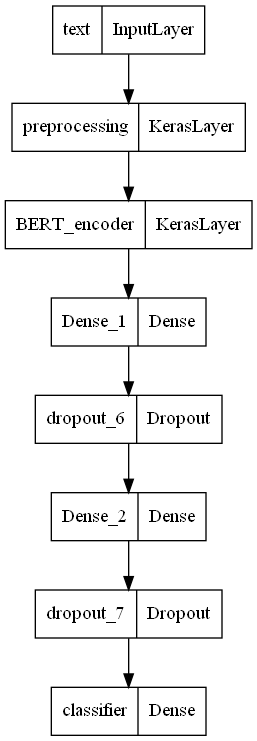

In [34]:
tf.keras.utils.plot_model(classifier_model)

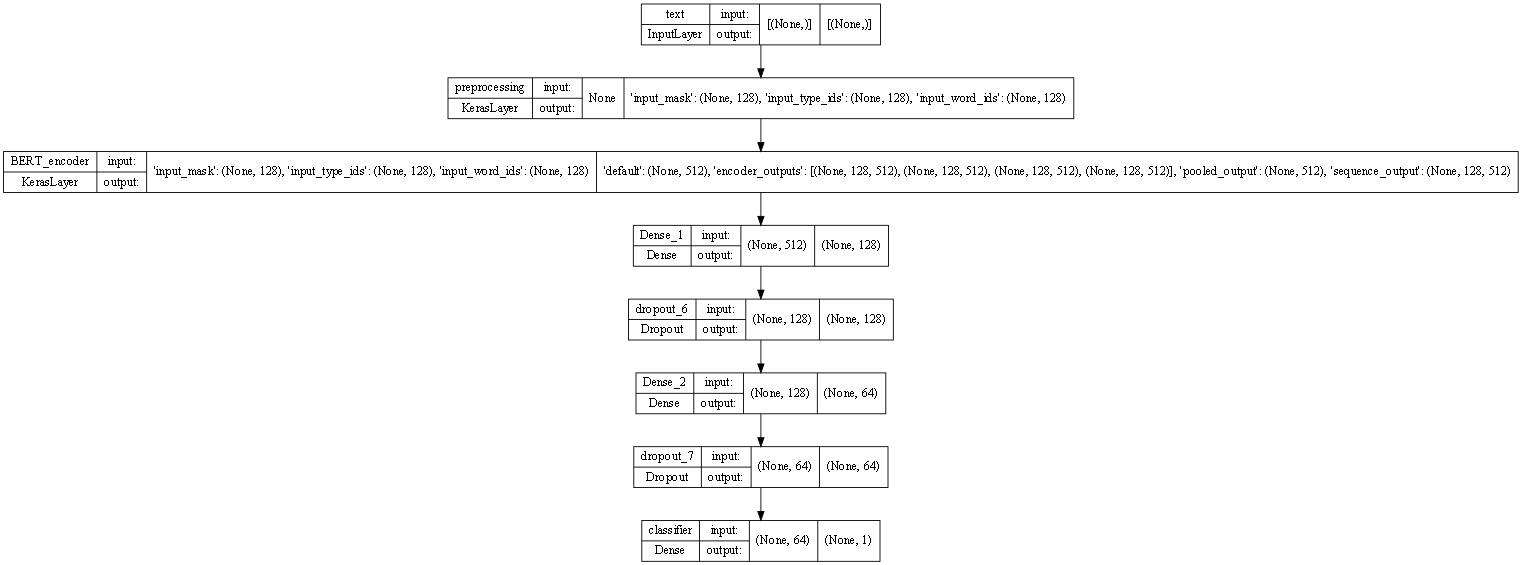

In [35]:
tf.keras.utils.plot_model(classifier_model, show_shapes=True, dpi=64)

In [36]:
print(text_test)
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

['this is such an amazing movie!']
tf.Tensor([[0.63391525]], shape=(1, 1), dtype=float32)


In [37]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [38]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [39]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [40]:
print(f'Training model with {tfhub_handle_encoder}')
with tf.device("/cpu:0"):
    history = classifier_model.fit(x=train_ds,
                                   validation_data=val_ds,
                                   epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5


C:\Users\lpdepersiis\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


625/625 [==============================] - 1290s 2s/step - loss: 0.6955 - binary_accuracy: 0.5538 - val_loss: 0.6376 - val_binary_accuracy: 0.6688
Epoch 2/5
625/625 [==============================] - 1307s 2s/step - loss: 0.6298 - binary_accuracy: 0.6475 - val_loss: 0.5954 - val_binary_accuracy: 0.6990
Epoch 3/5
625/625 [==============================] - 1266s 2s/step - loss: 0.6059 - binary_accuracy: 0.6740 - val_loss: 0.5779 - val_binary_accuracy: 0.7080
Epoch 4/5
625/625 [==============================] - 1256s 2s/step - loss: 0.5938 - binary_accuracy: 0.6827 - val_loss: 0.5696 - val_binary_accuracy: 0.7132
Epoch 5/5
625/625 [==============================] - 1248s 2s/step - loss: 0.5912 - binary_accuracy: 0.6881 - val_loss: 0.5670 - val_binary_accuracy: 0.7180


In [41]:
print(f'Training model with {tfhub_handle_encoder}')
with tf.device("/cpu:0"):
    history = classifier_model.fit(x=train_ds,
                                   validation_data=val_ds,
                                   epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 1249s 2s/step - loss: 0.5883 - binary_accuracy: 0.6890 - val_loss: 0.5670 - val_binary_accuracy: 0.7180
Epoch 2/5
625/625 [==============================] - 1257s 2s/step - loss: 0.5895 - binary_accuracy: 0.6891 - val_loss: 0.5670 - val_binary_accuracy: 0.7180
Epoch 3/5
625/625 [==============================] - 1251s 2s/step - loss: 0.5892 - binary_accuracy: 0.6898 - val_loss: 0.5670 - val_binary_accuracy: 0.7180
Epoch 4/5
625/625 [==============================] - 1245s 2s/step - loss: 0.5879 - binary_accuracy: 0.6887 - val_loss: 0.5670 - val_binary_accuracy: 0.7180
Epoch 5/5
625/625 [==============================] - 1287s 2s/step - loss: 0.5900 - binary_accuracy: 0.6867 - val_loss: 0.5670 - val_binary_accuracy: 0.7180


In [49]:
with tf.device("/cpu:0"):
    history = classifier_model.fit(x=train_ds,
                                   validation_data=val_ds,
                                   epochs=epochs)

Epoch 1/5
625/625 [==============================] - 5814s 9s/step - loss: 0.1359 - binary_accuracy: 0.9488 - val_loss: 0.4729 - val_binary_accuracy: 0.8524
Epoch 2/5
625/625 [==============================] - 5782s 9s/step - loss: 0.1367 - binary_accuracy: 0.9474 - val_loss: 0.4729 - val_binary_accuracy: 0.8524
Epoch 3/5
625/625 [==============================] - 8176s 13s/step - loss: 0.1380 - binary_accuracy: 0.9473 - val_loss: 0.4729 - val_binary_accuracy: 0.8524
Epoch 4/5
625/625 [==============================] - 6083s 10s/step - loss: 0.1365 - binary_accuracy: 0.9495 - val_loss: 0.4729 - val_binary_accuracy: 0.8524
Epoch 5/5
625/625 [==============================] - 5788s 9s/step - loss: 0.1375 - binary_accuracy: 0.9498 - val_loss: 0.4729 - val_binary_accuracy: 0.8524
